In [1]:
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from chadd import generate_bootstrap_distribution

In [2]:
aggregate_data_dir = "../data/aggregate/"
output_dir = "./img/"

device_name = "ibm_brisbane"
num_bootstrap_resamples = 10_000

In [3]:
aggregate_data_path = Path(aggregate_data_dir)
output_path = Path(output_dir)
output_path.mkdir(parents=True, exist_ok=True)
experiment_samples_file = aggregate_data_path / f"{device_name}" / "experiment_samples.pickle"
params_file = aggregate_data_path / f"{device_name}" / "params.yaml"

In [4]:
experiment_samples_df = pd.read_pickle(experiment_samples_file)
with open(params_file, "rb") as f:
    params = yaml.safe_load(f.read())
tau_min_ns = params['tau_min_ns']

In [5]:
experiment_samples_df

,prep_state,spectator_prep_state,dd_sequence,times_us,experiment_samples
0,+,1,idle,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.976273539661712, 0.579263220121738, 0.27352..."
1,+,1,XX-all,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9756864882976104, 0.8587151362496962, 0.636..."
2,+,1,XY4-all,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9791659050295898, 0.8669373680905087, 0.590..."
3,+,1,UR4-all,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9845964160425292, 0.8532927814066513, 0.618..."
4,+,1,XX,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9746553575122752, 0.9607275628767331, 0.962..."
...,...,...,...,...,...
209,-y,0,XY4,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9764147510244415, 0.9640562831647135, 0.959..."
210,-y,0,UR4,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.974086652829167, 0.9682613704772539, 0.9562..."
213,-y,0,CHaDD,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9720635201251374, 0.9683644761478893, 0.954..."
214,-y,0,multiaxis CHaDD,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9701373536804921, 0.9644047679473636, 0.958..."


In [6]:
dd_seqs = list(experiment_samples_df['dd_sequence'].unique())
dd_sequences_df = pd.DataFrame(columns=[
    'dd_sequence',
    'times_us', 'mus', 'sigmas',
])
for dd_sequence in dd_seqs:
    # create sub-dataframe consisting only of experiments for the given dd sequence across prep state settings
    dd_sequence_df = experiment_samples_df[experiment_samples_df['dd_sequence'] == dd_sequence]
    # create np.array of experiment samples across prep state settings (rows) for ease of column (time step) access
    array = []
    for idx in dd_sequence_df.index:
        times_us = dd_sequence_df.loc[idx, 'times_us']
        experiment_samples = dd_sequence_df.loc[idx, 'experiment_samples']
        array.append(experiment_samples)
    num_experiments, num_time_steps = np.array(array).shape
    mus = []
    sigmas = []
    for time_step in range(num_time_steps):
        # access column of experiment samples corresponding to time_step across prep state settings (rows)
        data = np.array(array)[:,time_step]
        # create a bootstrap distribution from experiment samples at time_step across prep state settings
        bootstrap_distribution = generate_bootstrap_distribution(
            data=data,
            statistic=np.mean,
            num_bootstrap_resamples=num_bootstrap_resamples,
        )
        mu = np.mean(bootstrap_distribution)
        sigma = np.std(bootstrap_distribution, ddof=1)
        mus.append(mu)
        sigmas.append(sigma)
    new_row = pd.DataFrame(
        {
            "dd_sequence": [dd_sequence],
            "times_us": [times_us],
            "mus": [mus],
            "sigmas": [sigmas],
        }
    )
    dd_sequences_df = pd.concat([dd_sequences_df, new_row], ignore_index=True)
dd_sequences_df = dd_sequences_df.set_index('dd_sequence')
dd_sequences_df

,times_us,mus,sigmas
dd_sequence,,,
idle,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9782463116124099, 0.825476319115651, 0.7050...","[0.0008169097829422704, 0.03701457117702313, 0..."
XX-all,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.978700687895199, 0.9037853105927068, 0.7643...","[0.0008934859945780605, 0.010850062800259531, ..."
XY4-all,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9779422544708978, 0.9058026312202608, 0.765...","[0.0007581758785384641, 0.010845680480690652, ..."
UR4-all,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9781628320508237, 0.9052925010925559, 0.765...","[0.000945514663595872, 0.010817448243931493, 0..."
XX,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9772450659229828, 0.9646409509305668, 0.953...","[0.0010543162523279977, 0.0012679353686866014,..."
XY4,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9778024925529751, 0.9658208671376498, 0.960...","[0.0009481715706863966, 0.00091935846120934, 0..."
UR4,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9786177152009901, 0.9664477481550175, 0.956...","[0.0008957269278512259, 0.001172517563591961, ..."
CHaDD,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9766637705726098, 0.965697203153243, 0.9597...","[0.0010261306338086996, 0.0013949845781314049,..."
multiaxis CHaDD,"[0.0, 1.9200000000000004, 3.8400000000000007, ...","[0.9782069113369626, 0.9631271462450081, 0.953...","[0.0008416044735643279, 0.001378029938995488, ..."


In [7]:
sequence_density_df = pd.DataFrame(
    {
        "dd_sequence": [
            'XX-all',
            'XY4-all',
            'UR4-all',
            'XX',
            'XY4',
            'UR4',
            'CHaDD',
            'multiaxis CHaDD',
            'CHaDD-R',
        ],
        "circ_depth": [4, 4, 4, 4, 4, 4, 4, 16, 8],
        "pulse_count": [4, 4, 4, 4, 4, 4, 8/3, 38/3, 16/3],
    }
)
sequence_density_df['seq_dur_ns'] = sequence_density_df['circ_depth'] * tau_min_ns
sequence_density_df['pulse_count_density'] = sequence_density_df['pulse_count'] / sequence_density_df['circ_depth']
sequence_density_df = sequence_density_df.set_index('dd_sequence')
sequence_density_df

,circ_depth,pulse_count,seq_dur_ns,pulse_count_density
dd_sequence,,,,
XX-all,4,4.000000,480.0,1.000000
XY4-all,4,4.000000,480.0,1.000000
UR4-all,4,4.000000,480.0,1.000000
XX,4,4.000000,480.0,1.000000
XY4,4,4.000000,480.0,1.000000
UR4,4,4.000000,480.0,1.000000
CHaDD,4,2.666667,480.0,0.666667
multiaxis CHaDD,16,12.666667,1920.0,0.791667
CHaDD-R,8,5.333333,960.0,0.666667


# Plotting experimental data in the CHaDD paper

## Plot settings

In [8]:
solid_marker_experiment_names = [
    'XX-all',
    'XY4-all',
    'UR4-all',
]

experiment_markers = {
    'idle': 'o',
    'XX': 's',
    'XX-all': 's',
    'XY4': 'h',
    'XY4-all': 'h',
    'UR4': 'P',
    'UR4-all': 'P',
    'CHaDD': 'D',
    'multiaxis CHaDD': 'H',
    'CHaDD-R': 'X',
}

experiment_marker_size = {
    'idle': 7,
    'XX': 6.5,
    'XX-all': 6.5,
    'XY4': 8,
    'XY4-all': 8,
    'UR4': 9,
    'UR4-all': 9,
    'CHaDD': 6,
    'multiaxis CHaDD': 8,
    'CHaDD-R': 8,
}

experiment_colors = {
    'idle': 'slategray',
    'XX': 'red',
    'XX-all': 'red',
    'XY4': 'darkorange',
    'XY4-all': 'darkorange',
    'UR4': 'gold',
    'UR4-all': 'gold',
    'CHaDD': 'darkviolet',
    'multiaxis CHaDD': 'blue',
    'CHaDD-R': 'green',
}

In [9]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{braket}'
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.dpi'] = 300

font_properties = {
    'fontsize': 16,  # set font size
    'fontname': 'Apple LiSung'  # specify the font name
}

In [10]:
def plot_selected_dd_seqs(
    selected_dd_seqs: list[str],
    plot_pulse_density: bool = False,
    num_legend_cols: int = 2,
    legend_fontsize: int = 11,
    legend_loc: int = 0,
    left_ylim: tuple = None,
    blank_indices: list[int] = None,
):
    fig, ax = plt.subplots()
    if plot_pulse_density:
        ax2 = ax.twinx()
        ax2.set_ylabel('average pulse count', fontdict=font_properties)
    handles = []
    labels = []
    for dd_seq in selected_dd_seqs:
        if dd_seq in dd_sequences_df.index:
            times_us = dd_sequences_df.loc[dd_seq, 'times_us']
            mus = dd_sequences_df.loc[dd_seq, 'mus']
            sigmas = dd_sequences_df.loc[dd_seq, 'sigmas']

            plot_options = {
                'label': dd_seq,
                'color': experiment_colors[dd_seq],
                'marker': experiment_markers[dd_seq],
                'markersize': experiment_marker_size[dd_seq],
                'markerfacecolor': 'none',
                'linewidth': 1.5,
                'elinewidth': 1.5,
                'capthick': 1.5,
                'capsize': 5,
            }
            if dd_seq in solid_marker_experiment_names:
                del plot_options['markerfacecolor']
                plot_options['linestyle'] = '--'
            handle = ax.errorbar(times_us, mus, sigmas, **plot_options)
            handles.append(handle)
            labels.append(dd_seq)

            if plot_pulse_density and dd_seq in sequence_density_df.index:
                pulse_count = sequence_density_df.loc[dd_seq, 'pulse_count']
                seq_dur_ns = sequence_density_df.loc[dd_seq, 'seq_dur_ns']
                cumulative_pulses = [pulse_count*time_us*1000/seq_dur_ns for time_us in times_us]
                ax2.plot(times_us, cumulative_pulses, color=experiment_colors[dd_seq], alpha=0.5)
                ax2.tick_params(axis='y', which='major', labelsize=14, direction='in')
                ax2.set_ylim(-20, 370)

    ax.tick_params(axis='both', which='major', labelsize=14, direction='in')
    ax.set_xlabel('time ($\\mu$s)', fontdict=font_properties)
    ax.set_ylabel('average fidelity', fontdict=font_properties)
    if left_ylim is not None:
        ax.set_ylim(left_ylim[0], left_ylim[1])

    if blank_indices is not None:
        from matplotlib.lines import Line2D
        blank_handle = Line2D([0],[0],color="w")
        for blank_idx in blank_indices:
            handles.insert(blank_idx, blank_handle)
            labels.insert(blank_idx, "")
    ax.legend(
        handles=handles, labels=labels,
        frameon=False, loc=legend_loc, fontsize=legend_fontsize, ncol=num_legend_cols,
    )
    plt.tight_layout(rect=[0, 0.04, 1, 1])

    experiment_labels_str = " ".join([
        dd_seq
        for dd_seq in selected_dd_seqs
        if dd_seq in dd_sequences_df.index
    ])
    plt.savefig(output_path / f"{device_name} {experiment_labels_str}")
    plt.show()

## Plots

In [11]:
selected_dd_seqs = [
    'idle',
    'XX-all',
    'XY4-all',
    'UR4-all',
    'XX',
    'XY4',
    'UR4',
    'CHaDD',
    'multiaxis CHaDD',
    'CHaDD-R',
]

### Figure 5

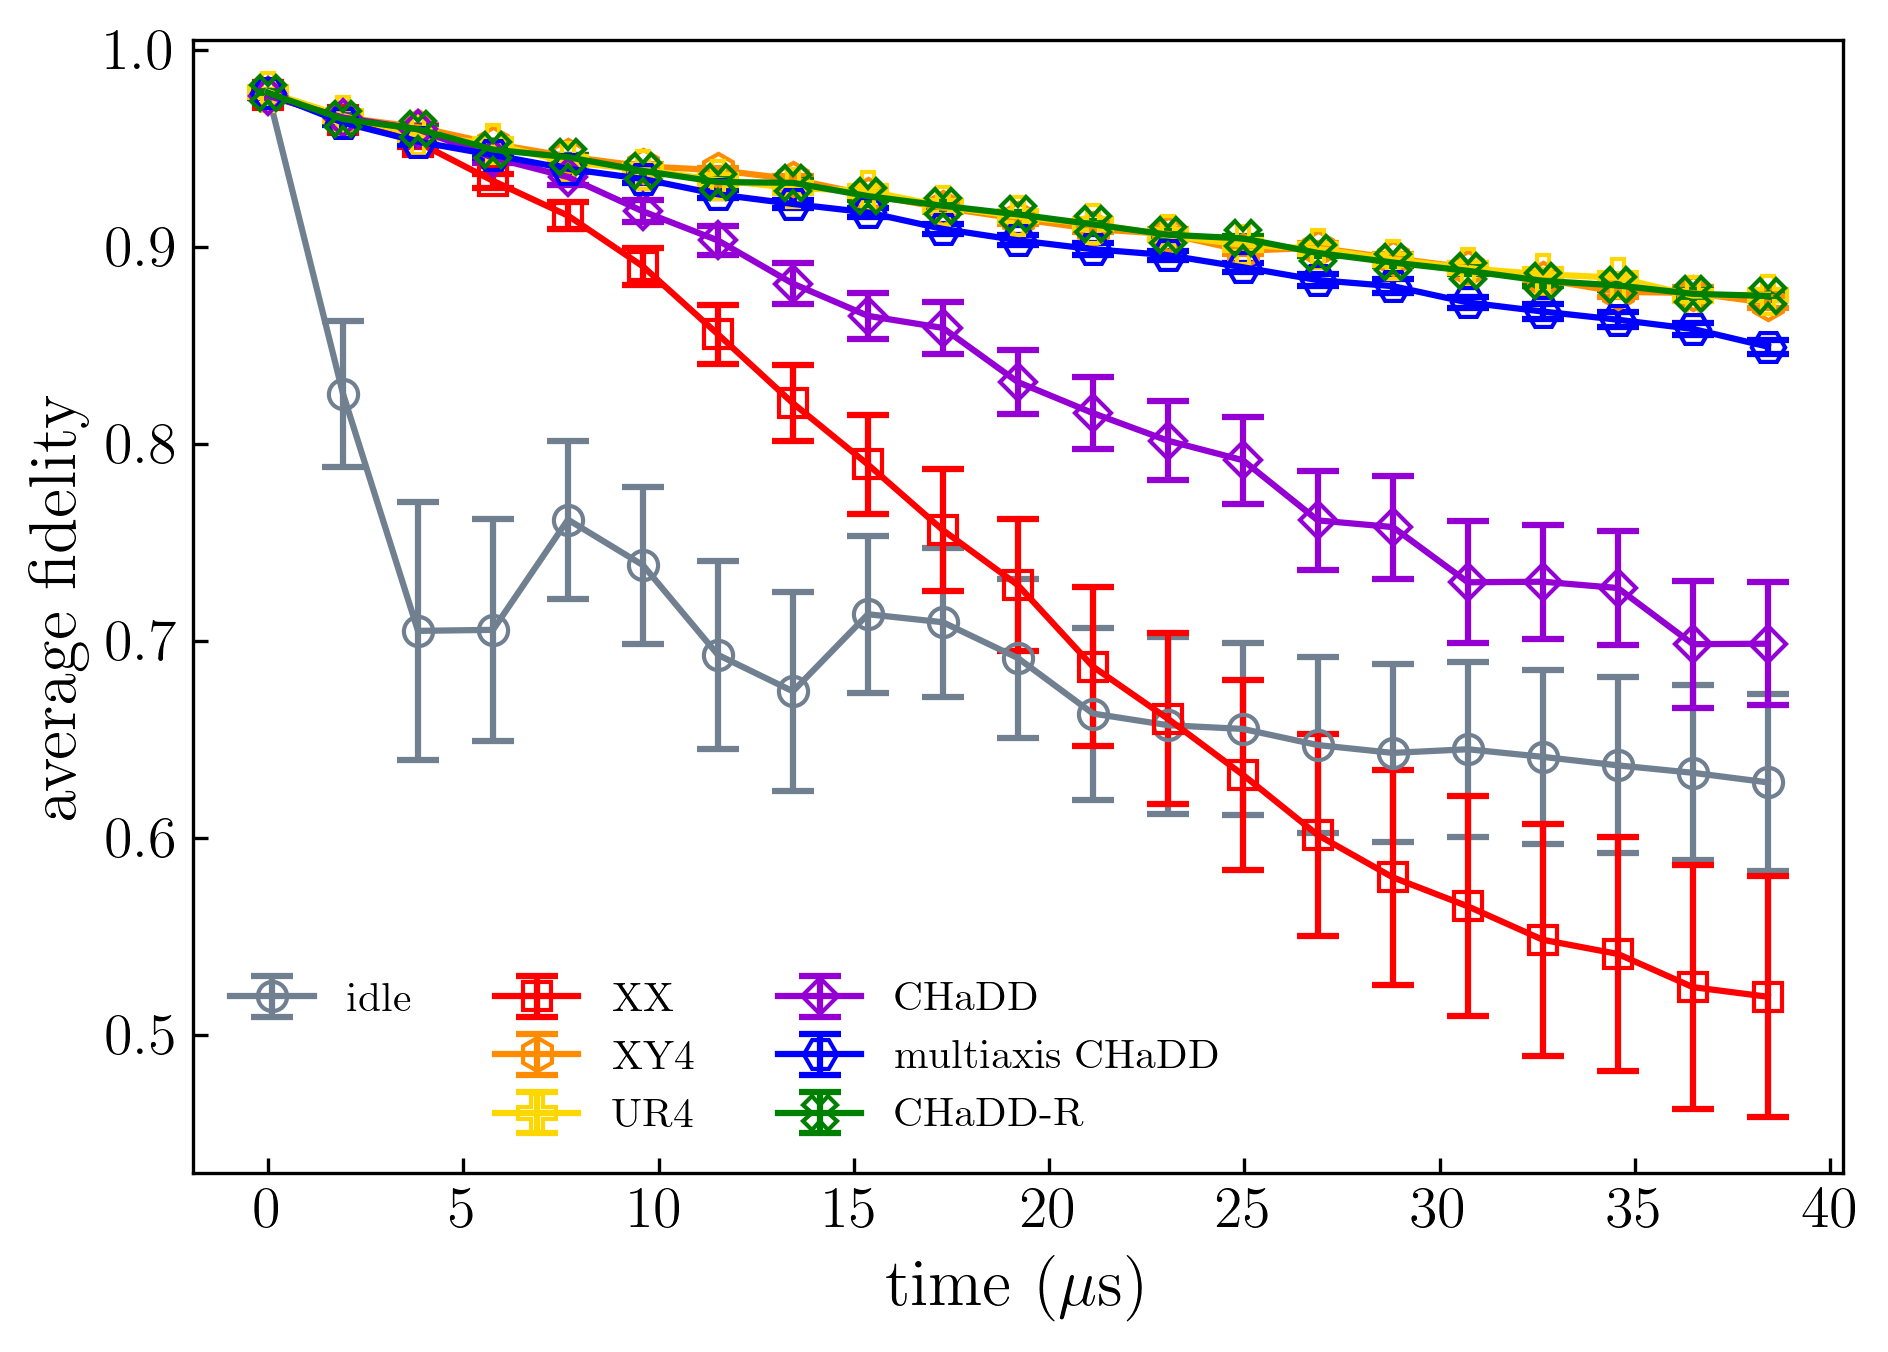

In [12]:
selected_dd_seqs = [
    'idle',
    'XX',
    'XY4',
    'UR4',
    'CHaDD',
    'multiaxis CHaDD',
    'CHaDD-R',
]
plot_selected_dd_seqs(
    selected_dd_seqs,
    num_legend_cols=3,
    legend_fontsize=10,
    legend_loc='lower left',
    blank_indices=[1,2],
    left_ylim=(0.43,1.005),
)

### Figure 6

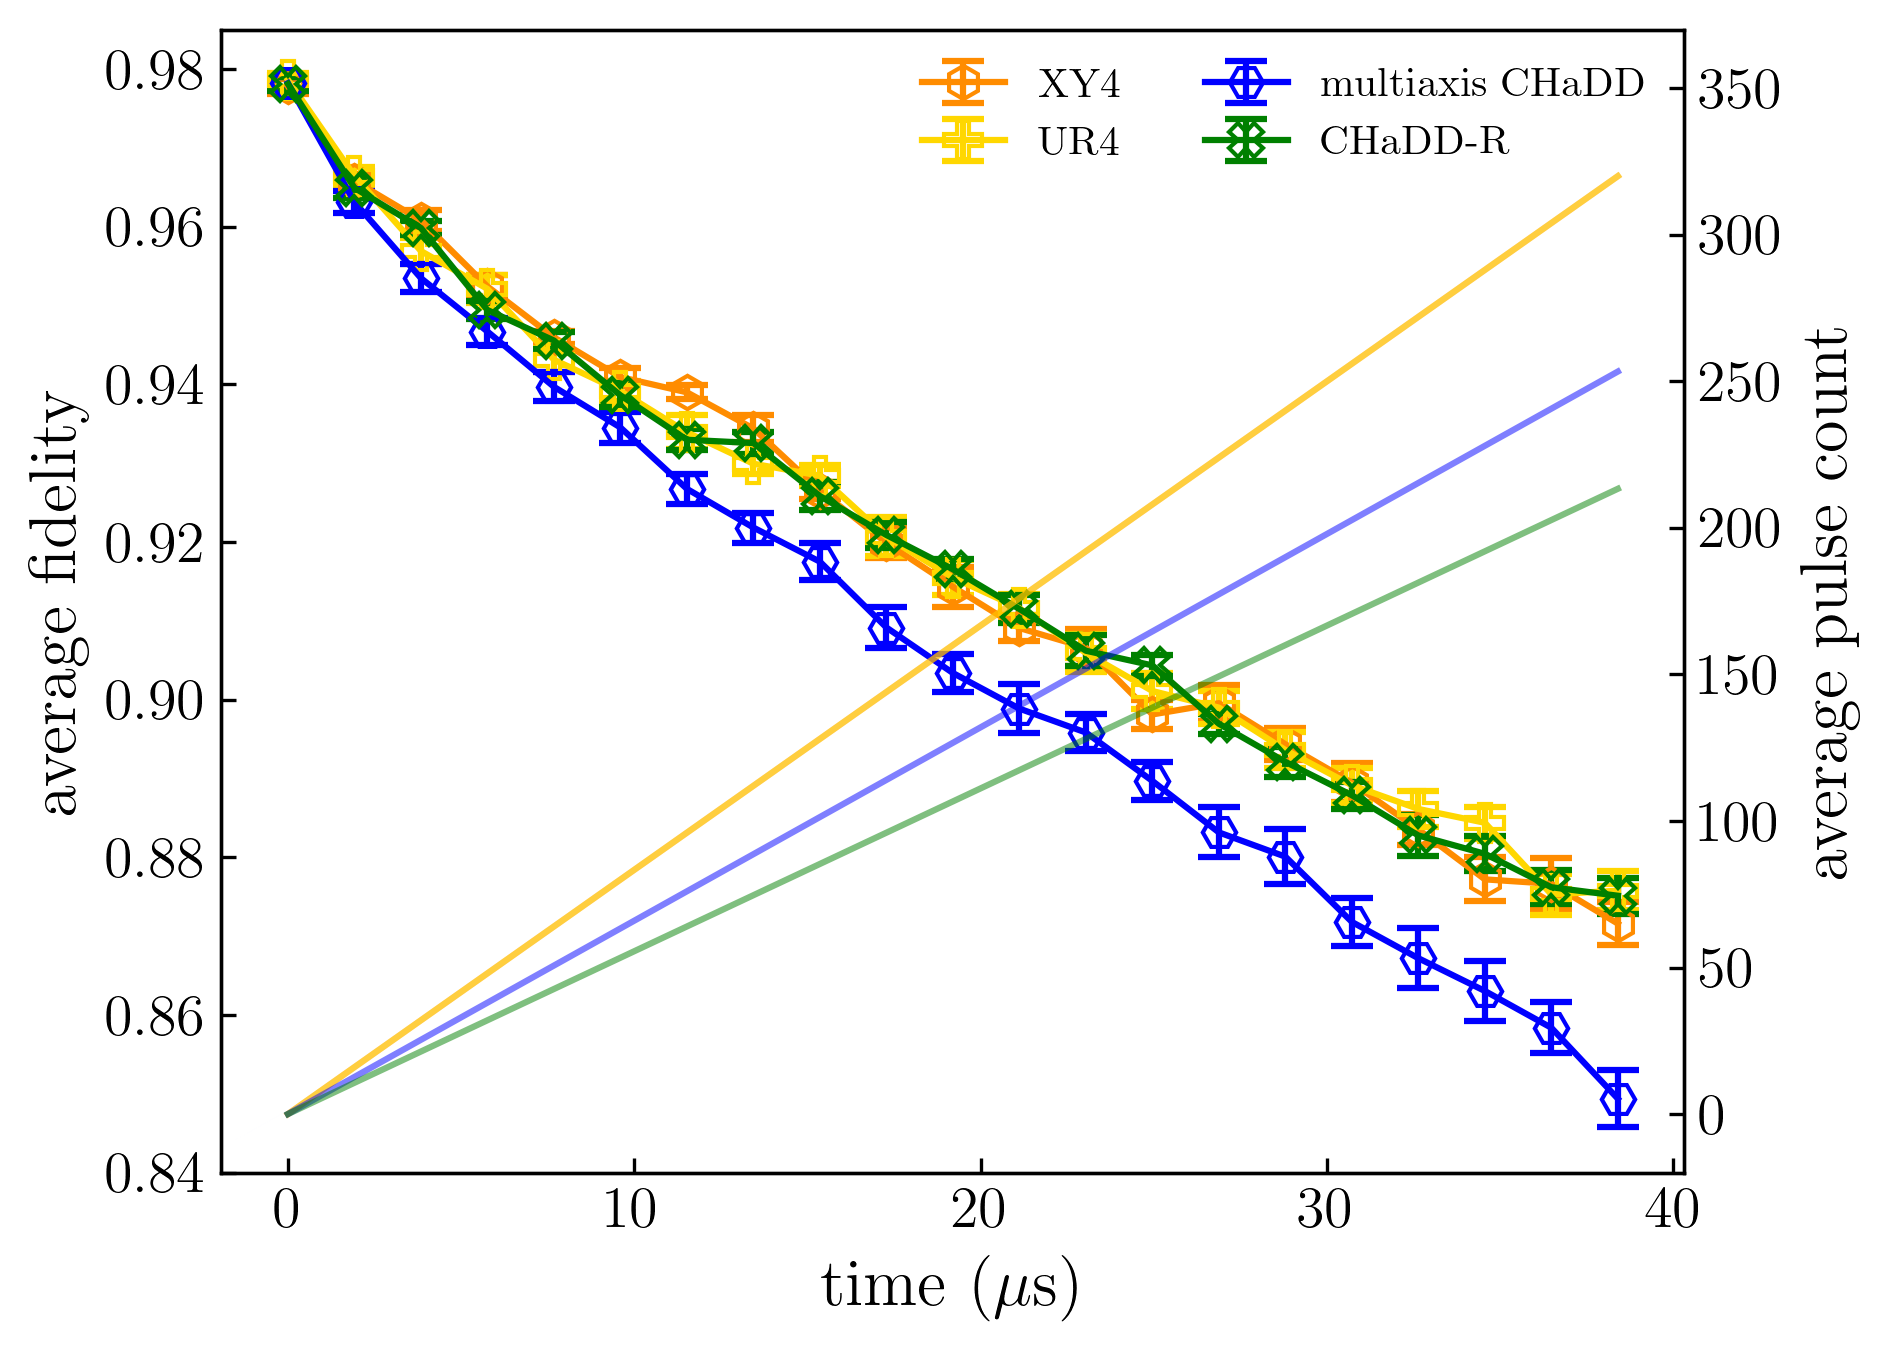

In [13]:
selected_dd_seqs = [
    'XY4',
    'UR4',
    'multiaxis CHaDD',
    'CHaDD-R',
]
plot_selected_dd_seqs(
    selected_dd_seqs,
    num_legend_cols=2,
    legend_fontsize=10,
#     legend_loc=(0.21,0.87),
    left_ylim=(0.84,0.985),
    # blank_indices=[0,2,3],
    plot_pulse_density=True,
)

### Figure 7

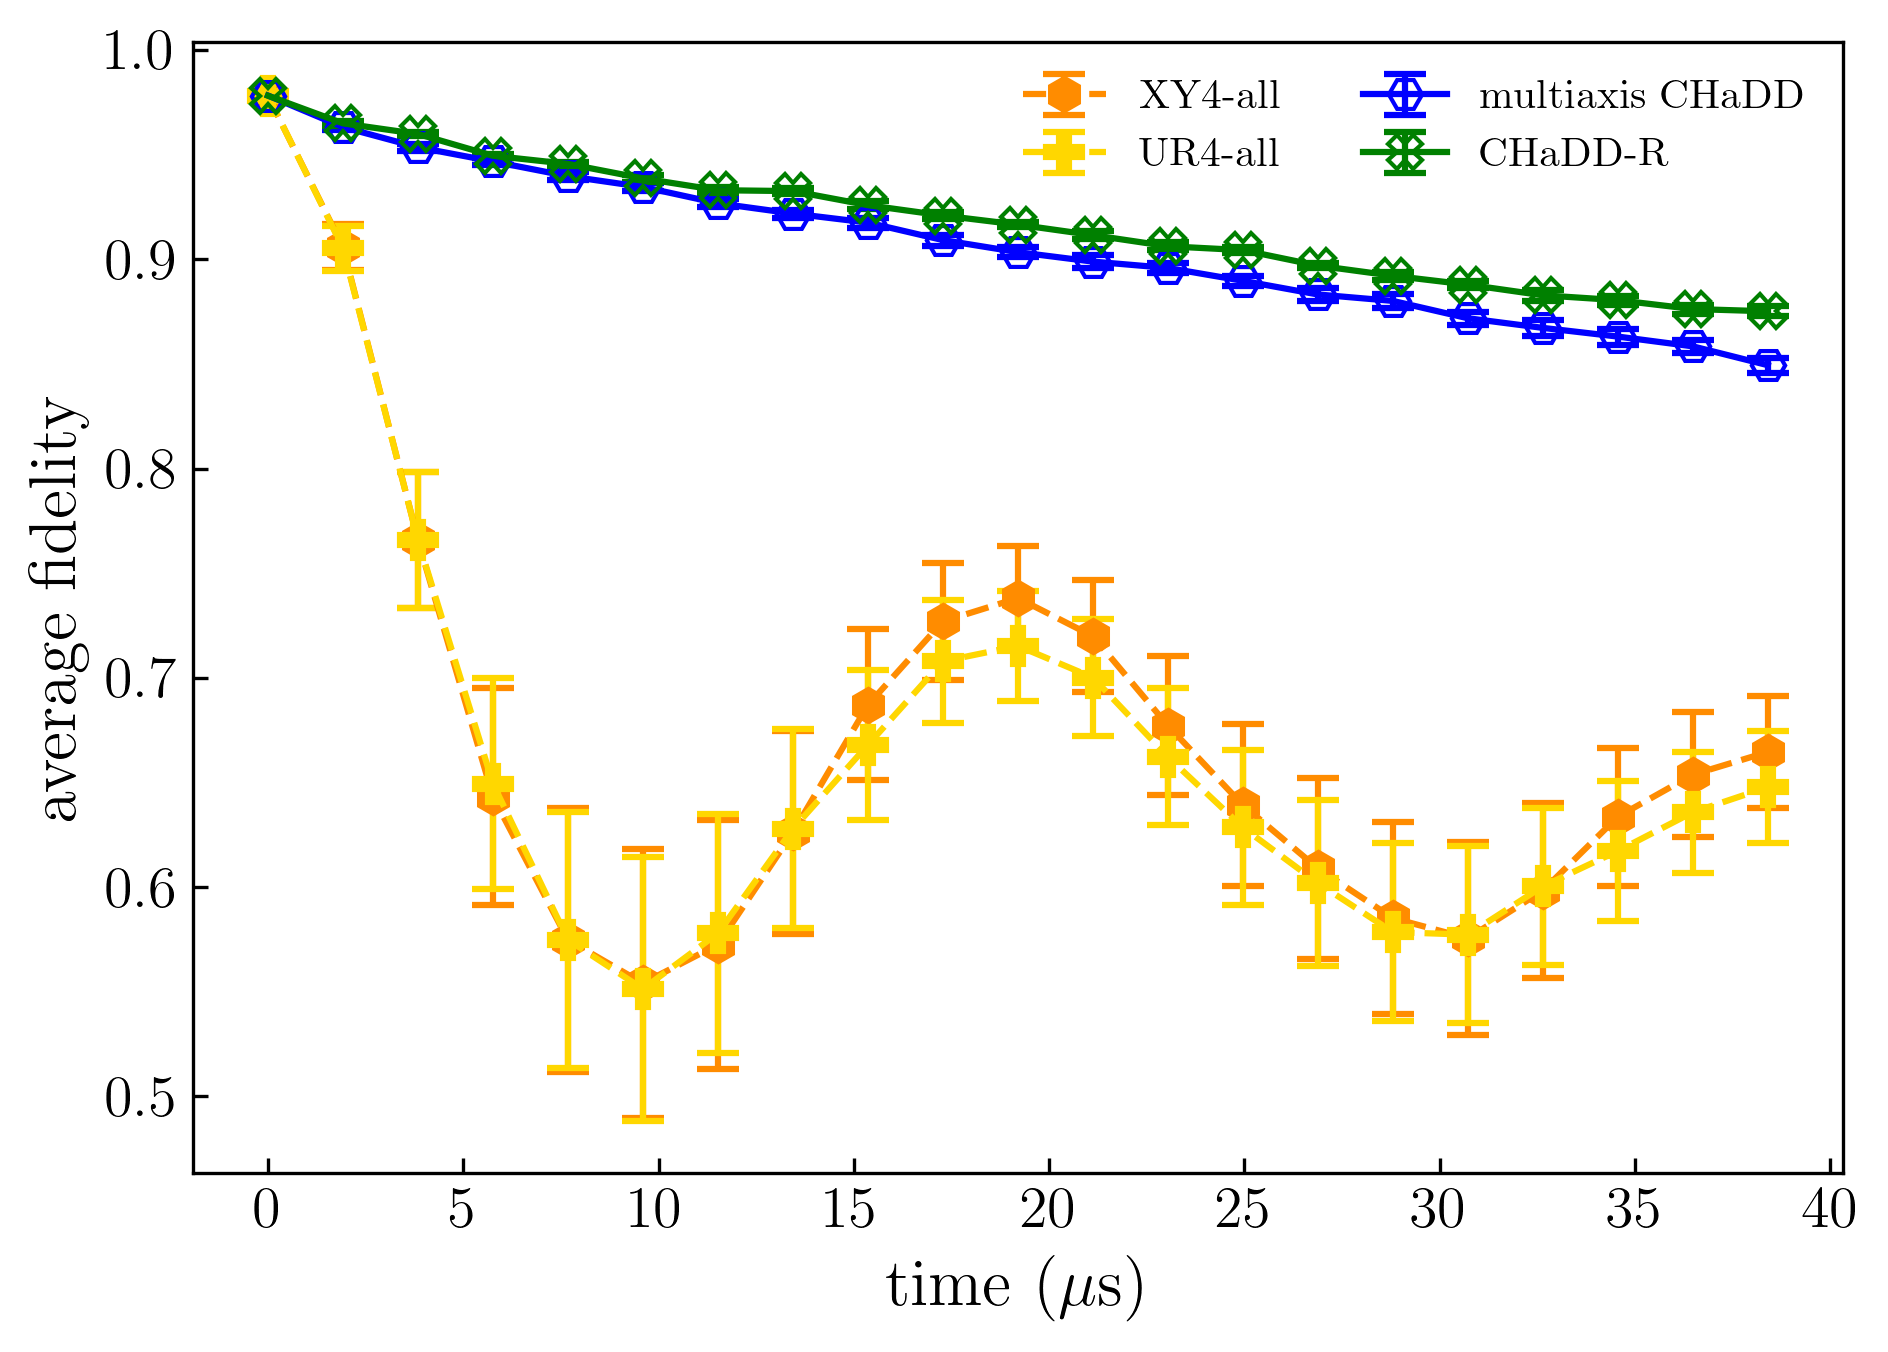

In [14]:
selected_dd_seqs = [
    'XY4-all',
    'UR4-all',
    'multiaxis CHaDD',
    'CHaDD-R',
]
plot_selected_dd_seqs(
    selected_dd_seqs,
    num_legend_cols=2,
    legend_fontsize=10,
#     legend_loc=(0.21,0.87),
#     left_ylim=(0.46,1.04),
#     plot_pulse_density=True,
)

### Additional plots

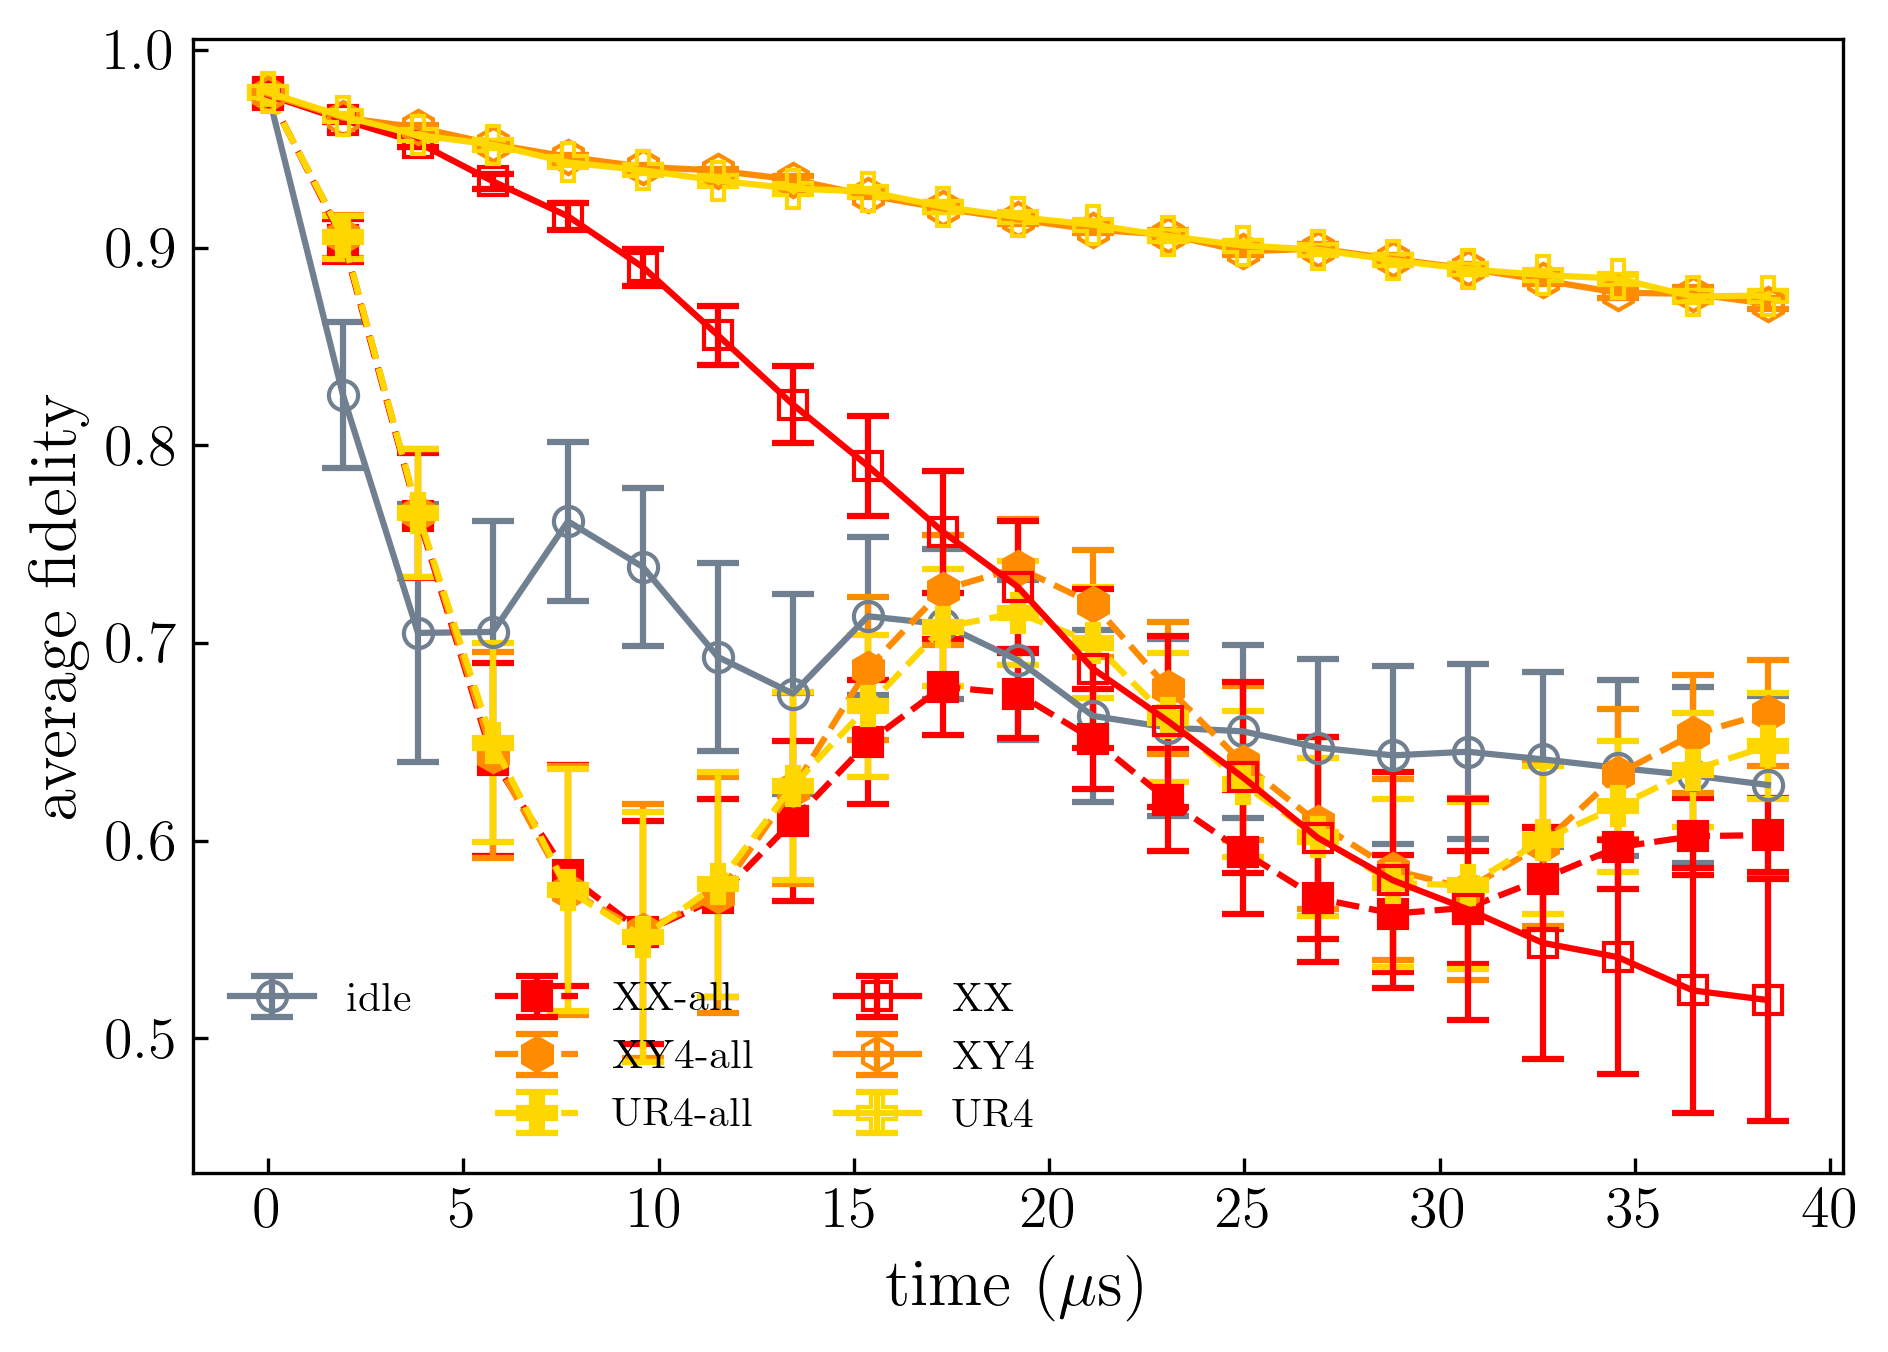

In [15]:
selected_dd_seqs = [
    'idle',
    'XX-all',
    'XY4-all',
    'UR4-all',
    'XX',
    'XY4',
    'UR4',
]
plot_selected_dd_seqs(
    selected_dd_seqs,
    num_legend_cols=3,
    legend_fontsize=10,
    blank_indices=[1,2],
#     legend_loc=(0.6, 0.5),
)

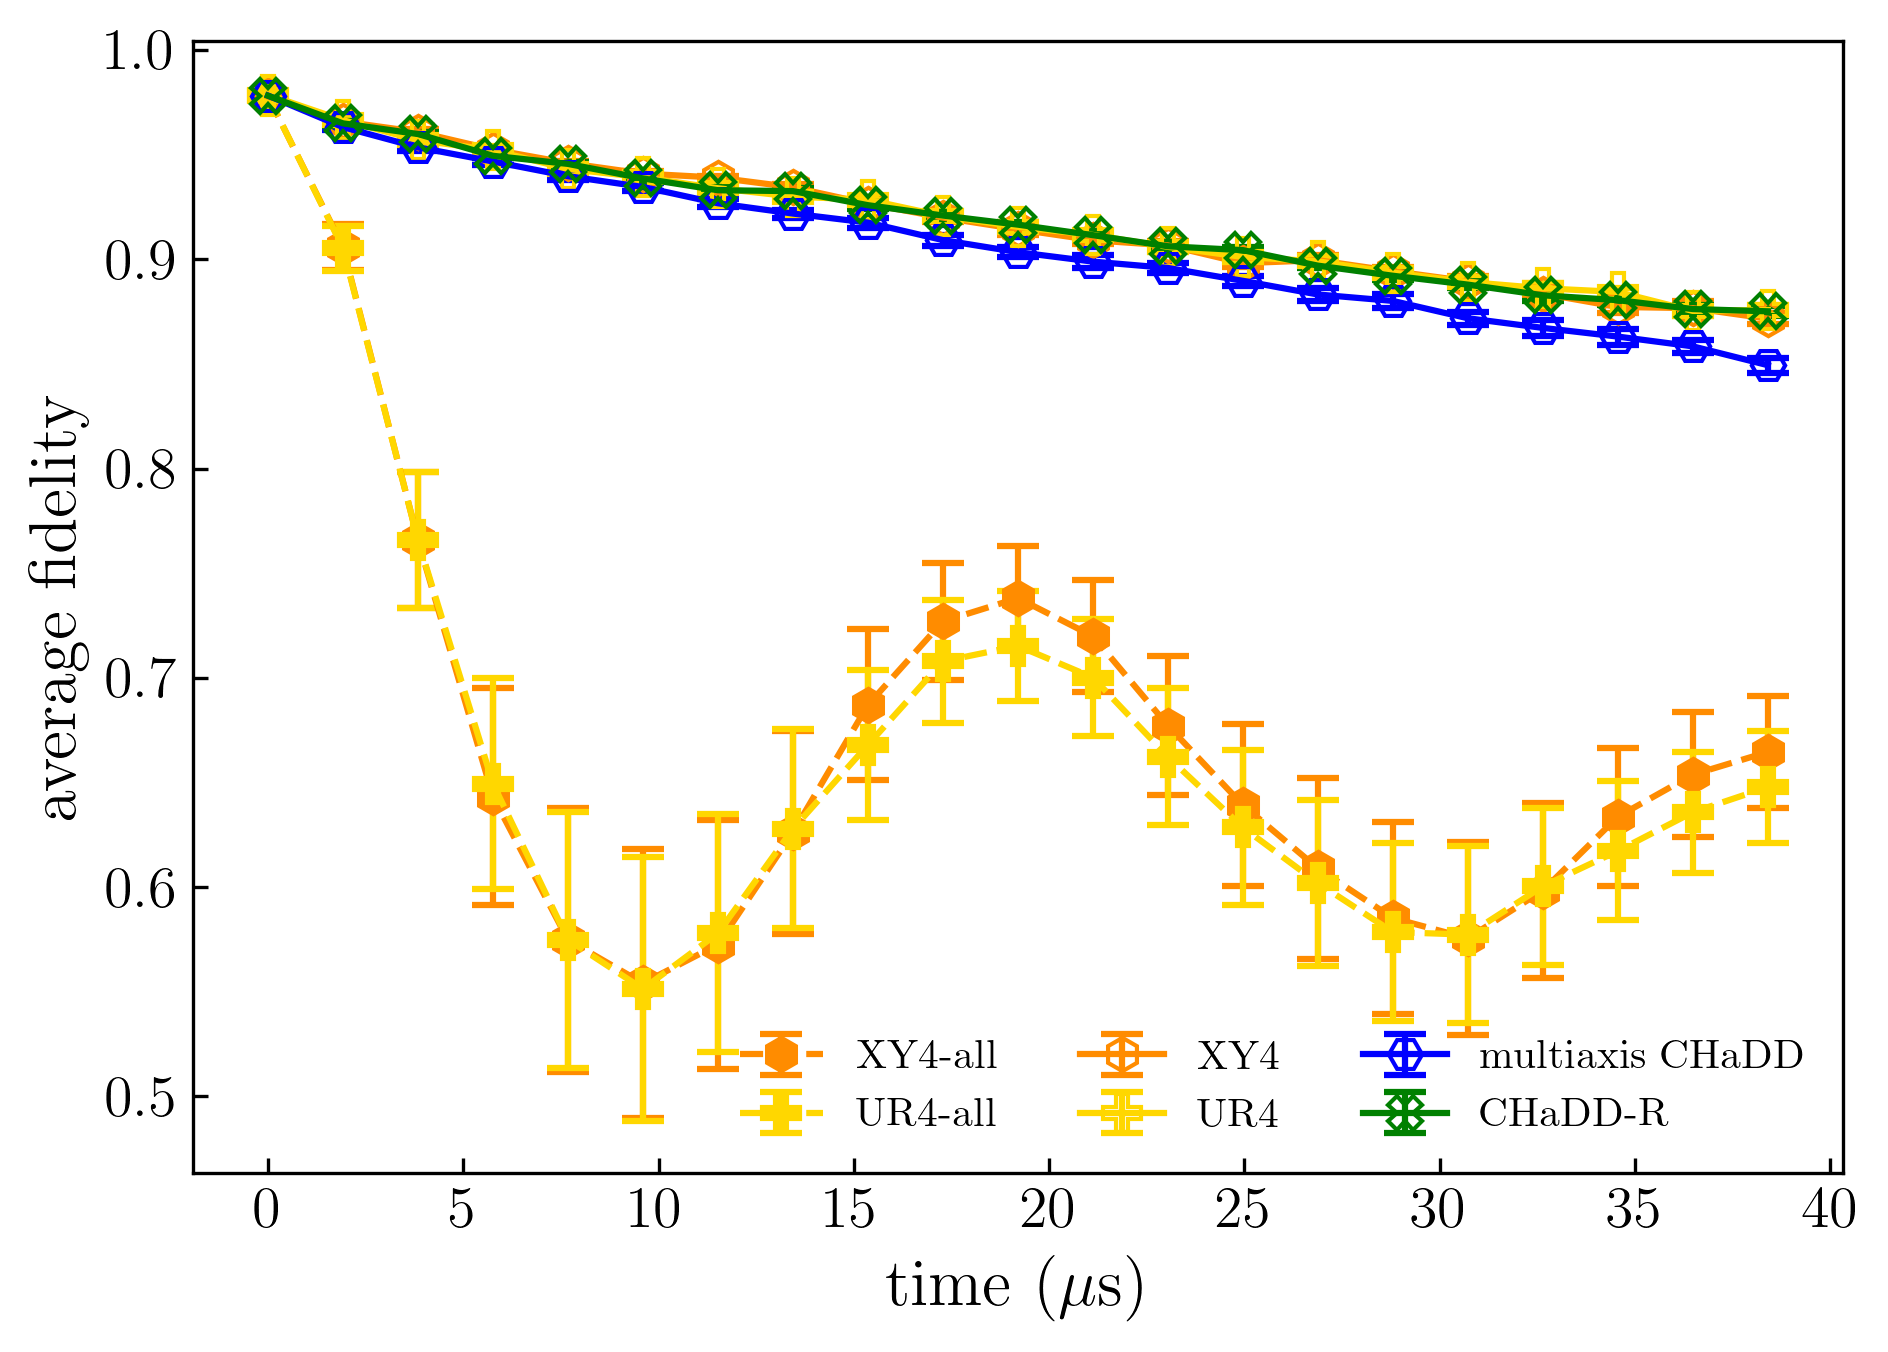

In [16]:
selected_dd_seqs = [
    'XY4-all',
    'UR4-all',
    'XY4',
    'UR4',
    'multiaxis CHaDD',
    'CHaDD-R',
]
plot_selected_dd_seqs(
    selected_dd_seqs,
    num_legend_cols=3,
    legend_fontsize=10,
#     legend_loc=(0.21,0.87),
#     left_ylim=(0.46,1.04),
#     plot_pulse_density=True,
)